<a href="https://colab.research.google.com/github/MayC06/FBmodel/blob/main/Simulating_Trajectories.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First, upload the following modules:
- PFN_model_CEM_offsets
- simulator_fly
- mpc_fly
- observability
- fisher
- figure_functions
- fly_plot_lib_plot
- setdict
- utils


In [ ]:
import sys
import os

import numpy as np
import pandas as pd
import math
import scipy
from scipy.io import savemat
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from matplotlib.colors import LogNorm, ListedColormap, LinearSegmentedColormap
import seaborn as sns
import pickle
import utils
import itertools
import tkinter as tk
from tkinter import filedialog

!pip install figurefirst
!pip install pynumdiff
!pip install casadi
!pip install do_mpc

import figure_functions as ff
import figurefirst as fifi

from PFN_model_CEM_offsets import PFN
from mpc_fly import MpcFlyWind
from observability import EmpiricalObservabilityMatrix, SlidingEmpiricalObservabilityMatrix
from fisher import FisherObservability
from math import ceil, floor



  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 10.2 MB/s eta 0:00:00
  Created wheel for figurefirst: filename=figurefirst-0.0.6-py3-none-any.whl size=46687 sha256=4c7ecd98ad61f6ac9cb509c925243a7e89edc9fd978be794b6029a05ffebb4fb
  Stored in directory: /root/.cache/pip/wheels/d6/b7/85/8d460cc7f13241e8e744eb2f624fab4598d397ebd88b0e821a
Successfully built figurefirst
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 MB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 5.3 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/do_mpc/sysid/__init__.py:15: UserWarning: The ONNX feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The ONNX feature is not available. Please install the full version of do-mpc to access this feature.')
/usr/local/lib/python3.11/dist-packages/do_mpc/opcua/__init__.py:14: UserWarning: The opcua feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The opcua feature is not available. Please install the full version of do-mpc to access this feature.')


0 0 0 0 zeta 3.142 windspeed 0.4 elevation 0.3


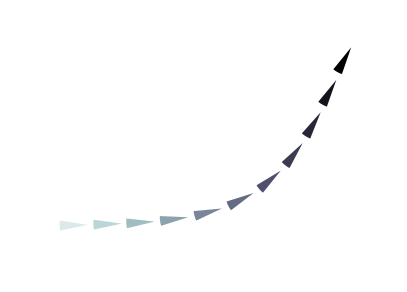

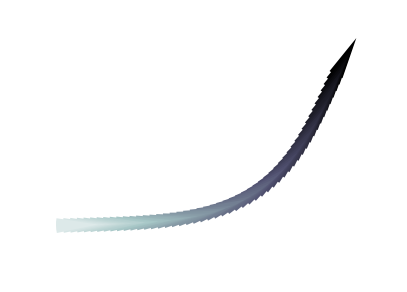

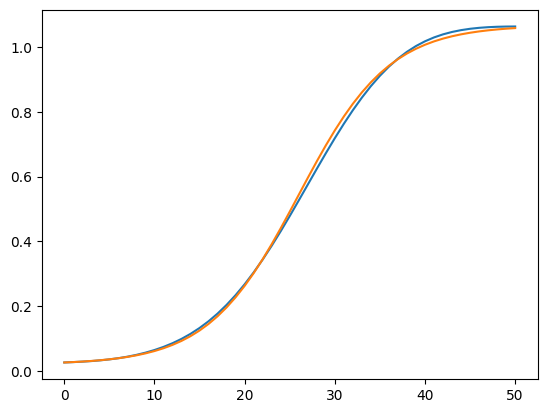

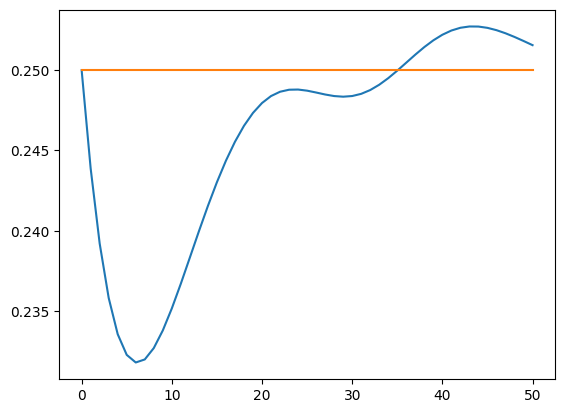

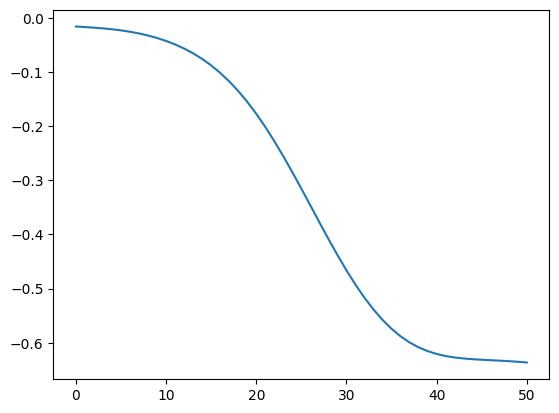

In [ ]:
plt.style.use('default')


# Set time
fs = 500
dt = 1 / fs
T = 0.1
tsim = np.arange(0.0, T + 0.9*dt, dt)
# tsim = tsim[1:]

# Noise
R = 0.1

# make up a trajectory
v_para_0 = [0.25] #[0.1# saccade lowest speed m/s  # [0.1,0.25,1.0]
v_para_dot_0 = 50.0 # m/s^2 ? # 50.0
# v_para_dot_0 = np.linspace(0.0,50.0,26)

v_perp_0 = 0.0
v_perp_dot_0 = 0.0
v_perp = v_perp_0*np.ones_like(tsim) + v_perp_dot_0*tsim

#phi_0 = np.linspace(-np.pi,np.pi,num=19) # shifted by 0.02 rad for off-wind
#phi_0[0]=-np.pi+0.02
#phi_0[9]=0.02
#phi_0[-1]=np.pi-0.02
phi_0 = [0.02]
# For a subset of phi_0
#phi_0 = [phi_0[i*3] for i in range(6)]
#phi_0 = np.append(phi_0,np.pi-0.02)

# w_0 = np.linspace(0.0,2.0,num=5)
#w_0 = [0.1,0.5,2.0]
w_0 = [0.4]                            # for observability
# w = w_0*np.ones_like(tsim)

# zeta_0 = [-np.pi/2]                         # for observability
#zeta_0 = np.linspace(-np.pi+0.04,np.pi+0.04,10)  # for ANN inputs
# For a subset of zeta_0
#zeta_0 = zeta_0[:9]
#zeta_0 = np.hstack((zeta_0[:4],zeta_0[5:]))
zeta_0 = [np.pi]

#deltaPhi = np.linspace(-np.pi,np.pi,num=26) # for ANN inputs
# deltaPhi = np.linspace(0,np.pi,num=26) # for observability
# deltaPhi = [-np.pi+np.pi/4]
deltaPhi = [np.pi/3] # turn magnitude in 100 ms, for observability dropout exps
# For a subset of deltaPhi
#deltaPhia = np.array([deltaPhi[i*2] for i in range(7)])
#deltaPhib = np.array([deltaPhi[i*2 + 13] for i in range(7)])
#deltaPhi = np.append(deltaPhia,deltaPhib)

elev = [0.3]
#elev = [0.3,1.0,2.0]

## Make variables to hold MPC output
t = np.zeros((1,1,10,26,19,len(tsim)))          # 3,10,26,19 training, 3,8,14,7 subset
ph = np.zeros((1,1,10,26,19,len(tsim)))
af = np.zeros((1,1,10,26,19,len(tsim)))
gam = np.zeros((1,1,10,26,19,len(tsim)))
grnd = np.zeros((1,1,10,26,19,len(tsim)))
ofdir = np.zeros((1,1,10,26,19,len(tsim)))
zs = np.zeros((1,1,10,26,19,len(tsim)))
wspds = np.zeros((1,1,10,26,19,len(tsim)))
altitude = np.zeros((1,1,10,26,19,len(tsim)))
fspd = np.zeros((1,1,10,26,19,len(tsim)))

time = np.array([]).reshape(0,1,10,26,19,len(tsim))     # 0,10,26,19 training, 0,8,14,7 subset
phis = np.array([]).reshape(0,1,10,26,19,len(tsim))
a = np.array([]).reshape(0,1,10,26,19,len(tsim))
gamma = np.array([]).reshape(0,1,10,26,19,len(tsim))
g = np.array([]).reshape(0,1,10,26,19,len(tsim))
psi = np.array([]).reshape(0,1,10,26,19,len(tsim))
zetas = np.array([]).reshape(0,1,10,26,19,len(tsim))
windspd = np.array([]).reshape(0,1,10,26,19,len(tsim))
alts = np.array([]).reshape(0,1,10,26,19,len(tsim))
fspds = np.array([]).reshape(0,1,10,26,19,len(tsim))

for v in v_para_0:

    m = 0
    for el in elev:                         # 3
        alt = el*np.ones_like(tsim)

        h = 0
        for wsp in w_0:                     # 3
            w = wsp*np.ones_like(tsim)

            k = 0
            for z in zeta_0:                # 10
                zeta = z*np.ones_like(tsim)

                i = 0
                for d in deltaPhi:          # 26
                # for v in v_para_dot_0:
                    j = 0
                    for s in phi_0:         # 19
                        #vpara_start = v_para_0*np.ones_like(tsim) #+ v_para_dot_0*tsim
                        #accel = v_para_dot_0*np.square(tsim[0:ceil(len(tsim)/2)]) #v_para_dot_0*np.square(...)
                        #v_para = vpara_start - np.append(accel,np.flip(accel[:-1]))
                        v_para = v_para_0*np.ones_like(tsim)                          # no decel

                        phi_start = s*np.ones_like(tsim)
                        angaccel = (d)/(1+np.exp(-100*(tsim-0.052)))
                        phi = phi_start + angaccel
                        # phi = s*np.ones_like(tsim) + (10*d)*tsim                      # constant turn
                        #phi = s*np.ones_like(tsim)                                      # no turn

                        # Reconstruct trajectory with MPC
                        fly_mpc = MpcFlyWind(v_para, v_perp, phi, w, zeta, alt, x0=None, dt=dt,
                                              n_horizon=10, r_weight=1e-7, run=True)

                        fly_mpc.plot_trajectory(arrow_size=0.002,nskip=4);\
                        plt.savefig('traj'+str(2)+'.svg')

                        # Save simulation data
                        sim_data = fly_mpc.sim_data_df.copy()

                        t[m,h,k,i,j,:] = tsim
                        ph[m,h,k,i,j,:] = np.round(sim_data['phi'],3)
                        af[m,h,k,i,j,:] = np.round(sim_data['a'],3)
                        gam[m,h,k,i,j,:] = np.round(sim_data['gamma'],3)
                        grnd[m,h,k,i,j,:] = np.round(sim_data['of'],3) # until 20250113, was taking sim_data['g']
                        ofdir[m,h,k,i,j,:] = np.round(sim_data['psi'],3)
                        zs[m,h,k,i,j,:]=np.round(sim_data['zeta'],3)
                        wspds[m,h,k,i,j,:]=np.round(sim_data['w'],3)
                        altitude[m,h,k,i,j,:]=np.round(sim_data['d'],3)
                        fspd[m,h,k,i,j,:]=np.round(sim_data['g'],3)

                        print(h,k,i,j,"zeta",np.round(z,3),"windspeed",wsp,"elevation",el)
                        j+=1

                    i+=1
                k+=1
            h+=1
        m+=1
    time = np.vstack([time,t])
    phis = np.vstack([phis,ph])
    a = np.vstack([a,af])
    gamma = np.vstack([gamma,gam])
    g = np.vstack([g,grnd])
    psi = np.vstack([psi,ofdir])
    zetas = np.vstack([zetas,zs])
    windspd = np.vstack([windspd,wspds])
    alts = np.vstack([alts,altitude])
    fspds = np.vstack([fspds,fspd])


fly_mpc.plot_trajectory(arrow_size=0.003);
#plt.savefig('traj4.svg')

fig, ax = plt.subplots();\
ax.plot(sim_data.phi);\
ax.plot(phi);

fig, ax = plt.subplots();\
ax.plot(sim_data.v_para);\
ax.plot(v_para);

fig,ax = plt.subplots();\
ax.plot(sim_data.gamma);


mdic = {"t":time,
        "heading":phis,
        "Atheta":gamma,
        "Amag":a,
        "Otheta":psi,
        "Omag":g,
        "Winddir":zetas,
        "Windspd":windspd,
        "Altitude":alts,
        "Flightspeed":fspds}
#savemat("threewindspds_saccadelike_lesscontrol_varaltitude_w05_elev20_fspd10.mat",mdic)